# Recommend System

## 추천시스템 알고리즘별 벡터화 필요여부

## 추천 알고리즘 선택 가이드 (Python 기반)

### 1. 데이터 상황별 가이드

| 데이터 상황 | 적합한 알고리즘 | 벡터 필요 여부 | 추천 라이브러리 |
|-------------|----------------|---------------|----------------|
| **사용자-아이템 평점 데이터** (예: 영화 평점, 별점) | 협업 필터링 (CF), 행렬 분해 | ✅ 필요 (잠재 벡터) | `surprise`, `implicit`, `lightfm` |
| **아이템의 텍스트/설명/메타데이터** (예: 뉴스 기사, 상품 설명) | 콘텐츠 기반 필터링 | ✅ 필요 (TF-IDF, 임베딩) | `scikit-learn`, `gensim`, `sentence-transformers` |
| **이미지/문서/임베딩 비교** | 벡터 검색 기반 | ✅ 필요 (고정 차원 벡터) | `faiss`, `annoy`, `hnswlib` |
| **명시적 룰 필요** (예: 최근 본 상품, 카테고리 추천) | 룰 기반 추천 | ❌ 불필요 | 직접 구현, `pandas`, SQL |
| **구매 이력 기반 패턴** (자주 같이 구매되는 상품) | 연관 규칙 기반 | ❌ 불필요 | `mlxtend`, `apyori` |
| **여러 신호 결합 필요** (예: 평점+텍스트+메타데이터) | 하이브리드 추천 | ⚠️ 혼합 | `lightfm`, 라이브러리 조합 |

---

### 2. 의사결정 플로우 (Decision Flow)
``` text
데이터가 무엇인가요?
 ├── 사용자-아이템 평점 → CF (Surprise, Implicit, LightFM)
 ├── 아이템 텍스트/설명 → 콘텐츠 기반 (scikit-learn, gensim, transformers)
 ├── 이미지/문서 임베딩 → 벡터 검색 (FAISS, Annoy, HNSWlib)
 ├── 단순 규칙/비즈니스 로직 → 룰 기반 (조건문, Pandas, SQL)
 ├── 장바구니/공동 구매 → 연관 규칙 (mlxtend, apyori)
 └── 여러 신호 조합 필요 → 하이브리드 (LightFM, 혼합)
```



### Tutorial

In [55]:
import numpy as np, pandas as pd, random            # 수치/데이터프레임/난수 유틸 임포트

# (개념) 추천 시스템에서는 보통 두 가지 데이터가 필요합니다:
# - 아이템 메타데이터(설명, 장르, 태그 등 → 콘텐츠 기반 추천에 사용)
# - 사용자-아이템 상호작용 로그(조회, 구매, 클릭 등 → 협업 필터링에 사용)

np.random.seed(42); random.seed(42)                 # 재현성 확보를 위한 시드 고정

# 사용자 / 아이템 수 설정
n_users, n_items = 20, 30                           # 사용자 20명, 아이템 30개
users = [f"u{idx:02d}" for idx in range(n_users)]   # 사용자 ID 리스트 생성: u00 ~ u19
items = [f"i{idx:02d}" for idx in range(n_items)]   # 아이템 ID 리스트 생성: i00 ~ i29

# 메타데이터 후보 정의
categories = ["book","movie","music","drama",]               # 카테고리 후보
tags_pool = ["ml","python","romance","action","jazz","design","stats","novel","drama","rock"]  # 태그 후보

# 아이템 메타데이터 생성 루프
item_meta = []                                      # 아이템 메타정보를 담을 리스트
for it in items:                                    # 모든 아이템에 대해
    cat = random.choice(categories)                 # 카테고리 랜덤 선택
    tags = random.sample(tags_pool, k=3)            # 태그 3개 랜덤 샘플링
    desc = f"{cat} with tags: {' '.join(tags)}. A {random.choice(['great','classic','modern','popular'])} {cat}."  # 설명 텍스트 생성
    item_meta.append((it, cat, tags, desc))         # (아이템ID, 카테고리, 태그리스트, 설명) 저장
item_meta = pd.DataFrame(item_meta, columns=["item_id","category","tags","description"])  # 데이터프레임 변환

# 사용자 선호(카테고리/태그) 생성
user_pref = pd.DataFrame({
    'user_id': users,                               # 사용자 ID
    'fav_cat': [random.choice(categories) for _ in users],   # 선호 카테고리 랜덤
    'fav_tag': [random.choice(tags_pool) for _ in users],    # 선호 태그 랜덤
})

# 사용자-아이템 상호작용(암묵적 피드) 생성
events = []                                         # (user_id, item_id, weight) 기록 리스트
for u in users:                                     # 각 사용자에 대해
    favc = user_pref[user_pref.user_id==u]['fav_cat'].values[0]  # 사용자의 선호 카테고리
    favt = user_pref[user_pref.user_id==u]['fav_tag'].values[0]  # 사용자의 선호 태그
    for it in random.sample(items, k=random.randint(8,12)):      # 임의의 아이템 8~12개 선택
        meta = item_meta[item_meta.item_id==it].iloc[0]          # 해당 아이템 메타데이터 조회
        base = 0.1                                               # 기본 클릭 확률
        if meta['category']==favc:                               # 선호 카테고리면
            base += 0.5                                          # 확률 가산
        if favt in meta['tags']:                                 # 선호 태그가 포함되면
            base += 0.3                                          # 확률 가산
        if random.random() < base:                               # 베르누이 시행으로 클릭 여부 결정
            events.append((u,it,1))                              # 클릭 시 weight=1 기록
            
interactions = pd.DataFrame(events, columns=["user_id","item_id","weight"])  # 상호작용 DF 생성
# (개념) interactions 데이터는 '사용자가 어떤 아이템을 소비했는가'를 보여줌
# 협업 필터링은 이 데이터를 기반으로 '비슷한 사용자/아이템'을 학습함
print("users:", len(users), "items:", len(items), "interactions:", len(interactions))  # 개수 출력
display(item_meta.head())                           # 아이템 메타데이터 미리보기
display(user_pref.head())                           # 사용자 선호 미리보기
display(interactions.head())                        # 상호작용 미리보기


users: 20 items: 30 interactions: 57


,item_id,category,tags,description
0,i00,book,"[ml, jazz, action]",book with tags: ml jazz action. A classic book.
1,i01,movie,"[python, drama, rock]",movie with tags: python drama rock. A popular ...
2,i02,book,"[ml, python, action]",book with tags: ml python action. A classic book.
3,i03,book,"[drama, action, stats]",book with tags: drama action stats. A classic ...
4,i04,drama,"[rock, jazz, ml]",drama with tags: rock jazz ml. A classic drama.


,user_id,fav_cat,fav_tag
0,u00,movie,ml
1,u01,movie,design
2,u02,music,python
3,u03,drama,drama
4,u04,music,action


,user_id,item_id,weight
0,u00,i13,1
1,u00,i23,1
2,u00,i01,1
3,u00,i26,1
4,u01,i27,1


#### Content Based Filtering (TF-IDF)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer  # TF-IDF 벡터화기
from sklearn.metrics.pairwise import cosine_similarity        # 코사인 유사도 함수

tfidf = TfidfVectorizer(max_features=1000)                    # 최대 500 피처로 TF-IDF 구성
X_tfidf = tfidf.fit_transform(item_meta['description'])      # 아이템 설명 텍스트 → TF-IDF 희소행렬
item_index = {it:i for i,it in enumerate(item_meta['item_id'])}  # 아이템ID→인덱스 매핑

# (개념) 콘텐츠 기반 추천:
# 아이템 설명(텍스트)을 수치 벡터로 변환해야 유사도 계산 가능
# TF-IDF는 각 단어의 중요도를 반영 → '유사한 설명을 가진 아이템 = 유사 아이템'

# ============================
# 3. 콘텐츠 기반 추천 함수
# ============================
def content_rank_for_user(user_id, topk=5):
    # 사용자가 본 아이템 리스트
    seen = interactions[interactions.user_id==user_id]['item_id'].tolist()
    # item_index에 없는 아이템이 섞여 있으면 제거
    seen = [it for it in seen if it in item_index]
    if not seen:
        return pd.DataFrame([], columns=["item_id","score"])

    # 본 아이템들의 TF-IDF 평균 벡터 (np.matrix → ndarray 변환)
    idxs = [item_index[it] for it in seen]              # TF-IDF 행 인덱스
    user_vec = np.asarray(X_tfidf[idxs].mean(axis=0))   # (1, d) 모양

    # 전체 아이템과 코사인 유사도
    sims = cosine_similarity(user_vec, X_tfidf).ravel() # (n_items, )

    # 마스크: 이미 본 아이템 제외
    n_items = X_tfidf.shape[0]                          # TF-IDF 기준 아이템 수
    mask = np.ones(n_items, dtype=bool)
    mask[idxs] = False

    # 후보 스코어: item_meta에서 안전하게 ID 추출
    cand_scores = [(item_meta['item_id'].iloc[i], float(sims[i]))
                   for i in range(n_items) if mask[i]]
    cand_scores.sort(key=lambda x: -x[1])

    return pd.DataFrame(cand_scores[:topk], columns=["item_id","score"])

# (개념) 콘텐츠 기반 추천은 '사용자 프로필(본 아이템 벡터의 평균)'과
# '전체 아이템 벡터' 사이 유사도를 계산하여 점수가 높은 아이템을 추천

content_rank_for_user('u00')

,item_id,score
0,i16,0.809558
1,i12,0.769325
2,i09,0.762035
3,i27,0.679027
4,i04,0.506528


#### Collaborative Filtering (item-item CF)

In [57]:
from sklearn.metrics.pairwise import cosine_similarity        # 코사인 유사도
import numpy as np                                            # 수치 연산
import pandas as pd                                           # 데이터프레임

user_index = {u:i for i,u in enumerate(users)}                # 사용자ID→인덱스 매핑
item_index = {it:i for i,it in enumerate(items)}              # 아이템ID→인덱스 매핑

UI = np.zeros((len(users), len(items)), dtype=np.float32)     # 사용자-아이템 상호작용 행렬 초기화
for _, row in interactions.iterrows():                        # 상호작용 데이터를 순회하며
    UI[user_index[row.user_id], item_index[row.item_id]] = row.weight  # 해당 위치에 가중치 기록(implicit 1)

item_sims = cosine_similarity(UI.T)                           # 아이템 벡터 간 코사인 유사도 행렬 (열 기준)

def itemcf_rank_for_user(user_id, topk=10):                   # 특정 사용자에 대한 아이템CF 추천 함수
    uidx = user_index[user_id]                                # 사용자 인덱스
    user_vec = UI[uidx]                                       # 사용자의 아이템 상호작용 벡터
    seen_idxs = np.where(user_vec>0)[0]                       # 이미 본 아이템 인덱스들
    scores = np.zeros(len(items))                             # 후보 점수 배열
    for i in seen_idxs:                                       # 본 아이템 각각에 대해
        scores += item_sims[i]                                # 유사 아이템들의 유사도를 가산(이웃 가중합)
    scores[seen_idxs] = -1e9                                  # 이미 본 아이템은 매우 작은 값으로 제외
    top = np.argsort(-scores)[:topk]                          # 상위 topk 인덱스 선택
    return pd.DataFrame({"item_id":[items[i] for i in top], "score":scores[top]})  # 결과 DF 반환

itemcf_rank_for_user("u00", topk=5)                           # 예시 실행

,item_id,score
0,i03,1.115355
1,i27,0.929019
2,i22,0.866025
3,i29,0.761802
4,i10,0.707107


#### Hybrid Recommendation

In [58]:
# =========================
# 패치: 안전 인덱싱 + 함수 재정의
# =========================

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# --- 안전 인덱싱 유틸 (이미 있으셔도 다시 덮어써도 됩니다) ---
def _get_n_items(items_obj):
    """items가 list이면 len, DataFrame이면 shape[0]"""
    return len(items_obj) if isinstance(items_obj, list) else items_obj.shape[0]

def _get_item_id(items_obj, idx):
    """items가 list이면 items[idx], DataFrame이면 items.loc[idx, 'item_id']"""
    if isinstance(items_obj, list):
        return items_obj[idx]
    else:
        return items_obj.loc[idx, 'item_id']

# --- 콘텐츠 기반 추천 재정의: 안전 인덱싱 적용 ---
def content_rank_for_user(user_id, topk=10):
    # 사용자가 본 아이템
    seen = interactions[interactions.user_id==user_id]['item_id'].tolist()
    if not seen:
        return pd.DataFrame([], columns=["item_id","score"])

    # 본 아이템들의 TF-IDF 평균 벡터 (np.matrix → ndarray 변환)
    idxs = [item_index[it] for it in seen]              # item_index: 아이템ID → 벡터 행 인덱스
    user_vec = np.asarray(X_tfidf[idxs].mean(axis=0))

    # 전체 아이템과 유사도
    n_items = _get_n_items(items)
    sims = cosine_similarity(user_vec, X_tfidf).ravel()

    # 이미 본 아이템 제외
    mask = np.ones(n_items, dtype=bool)
    for it in seen:
        mask[item_index[it]] = False

    # 후보 스코어 (아이템ID를 타입에 맞게 안전하게 꺼낸다)
    cand_scores = [(_get_item_id(items, i), float(sims[i]))
                   for i in range(n_items) if mask[i]]
    cand_scores.sort(key=lambda x: -x[1])
    return pd.DataFrame(cand_scores[:topk], columns=["item_id","score"])

# --- 아이템CF 추천 재정의: 안전 인덱싱 적용 ---
def itemcf_rank_for_user(user_id, topk=10):
    uidx = user_index[user_id]
    user_vec = UI[uidx]
    seen_idxs = np.where(user_vec > 0)[0]

    n_items = _get_n_items(items)
    scores = np.zeros(n_items)
    for i in seen_idxs:
        scores += item_sims[i]
    scores[seen_idxs] = -1e9  # 이미 본 아이템 제외

    top = np.argsort(-scores)[:topk]
    return pd.DataFrame({
        "item_id": [_get_item_id(items, i) for i in top],
        "score": scores[top]
    })

# --- 블렌딩(이브리드) 유지 ---
def minmax_normalize(df, col='score'):
    if df.empty:
        return df
    mn, mx = df[col].min(), df[col].max()
    if mx - mn < 1e-9:
        df[col] = 0.0
    else:
        df[col] = (df[col] - mn) / (mx - mn)
    return df

def hybrid_rank(user_id, w_content=0.5, w_cf=0.5, topk=10):
    n_items = _get_n_items(items)
    cdf = content_rank_for_user(user_id, topk=n_items)
    idf = itemcf_rank_for_user(user_id, topk=n_items)
    cdf = minmax_normalize(cdf)
    idf = minmax_normalize(idf)
    merged = pd.merge(cdf, idf, on='item_id', how='outer',
                      suffixes=('_content','_cf')).fillna(0.0)
    merged['hyb'] = w_content*merged['score_content'] + w_cf*merged['score_cf']
    merged.sort_values('hyb', ascending=False, inplace=True)
    return merged.head(topk)

# --- 빠른 동작 확인 ---
print(hybrid_rank("u00", w_content=0.6, w_cf=0.4, topk=10))

   item_id  score_content  score_cf       hyb
16     i16       1.000000       1.0  1.000000
12     i12       0.938806       1.0  0.963284
9      i09       0.927718       1.0  0.956631
27     i27       0.801463       1.0  0.880878
4      i04       0.539092       1.0  0.723455
20     i20       0.454319       1.0  0.672591
15     i15       0.437877       1.0  0.662726
5      i05       0.435069       1.0  0.661042
28     i28       0.399618       1.0  0.639771
11     i11       0.379293       1.0  0.627576


In [59]:
import math                                                   # 로그 계산 등 수학 함수
import random                                                 # 랜덤 분할에 사용

def recall_at_k(gt_items, rec_items, k=10):                   # Recall@K 계산
    if len(gt_items)==0: return 0.0                           # GT 비어있으면 0
    return len(set(gt_items) & set(rec_items[:k])) / float(len(gt_items))  # 교집합/GT 크기

def ndcg_at_k(gt_items, rec_items, k=10):                     # NDCG@K 계산 (binary rel)
    dcg = 0.0                                                 # 누적 DCG 초기화
    for rank, it in enumerate(rec_items[:k], start=1):        # 추천 상위 K 순회
        rel = 1.0 if it in gt_items else 0.0                  # 해당 아이템이 정답이면 1
        if rel>0:
            dcg += rel / math.log2(rank+1)                    # 위치 가중 로그 할인
    idcg = 0.0                                                # 이상적 DCG
    for rank in range(1, min(k, len(gt_items))+1):            # 정답 수만큼 이상적 순위 가정
        idcg += 1.0 / math.log2(rank+1)
    return dcg / idcg if idcg>0 else 0.0                      # 정규화된 DCG 반환

u = "u00"                                                     # 평가 타깃 사용자
u_hist = interactions[interactions.user_id==u]['item_id'].tolist()  # 사용자 히스토리
random.shuffle(u_hist)                                        # 랜덤 셔플
split = max(1, int(len(u_hist)*0.7))                          # 70% 학습, 30% 검증 분할
train_seen, test_gt = set(u_hist[:split]), set(u_hist[split:])# 학습에서 본 아이템, 검증 정답
print("train_seen:", train_seen, "test_gt:", test_gt)         # 분할 결과 출력

interactions_train = interactions.copy()                      # 학습용 상호작용 복사
mask = (interactions_train.user_id==u) & (~interactions_train.item_id.isin(train_seen))  # 검증 아이템 마스크
interactions_train = interactions_train[~mask]                # 검증 아이템 제거(학습 데이터화)

UI_train = np.zeros((len(users), len(items)), dtype=np.float32)     # 학습용 UI 행렬
for _, row in interactions_train.iterrows():                         # 학습 상호작용 반영
    UI_train[user_index[row.user_id], item_index[row.item_id]] = row.weight
item_sims_train = cosine_similarity(UI_train.T)                      # 학습용 아이템 유사도

def itemcf_rank_for_user_train(user_id, topk=10):            # 학습 분할 기준의 CF 추천
    uidx = user_index[user_id]                                # 사용자 인덱스
    user_vec = UI_train[uidx]                                 # 사용자 벡터
    seen_idxs = np.where(user_vec>0)[0]                       # 학습에서 본 아이템 인덱스
    scores = np.zeros(len(items))                             # 점수 초기화
    for i in seen_idxs:                                       # 본 아이템들의 유사도 누적
        scores += item_sims_train[i]
    scores[seen_idxs] = -1e9                                  # 본 아이템 제외
    top = np.argsort(-scores)[:topk]                          # 상위 topk
    return pd.DataFrame({"item_id":[items[i] for i in top], "score":scores[top]})  # 결과

def content_rank_for_user_train(user_id, topk=10):           # 학습 분할 기준의 콘텐츠 추천
    seen = interactions_train[interactions_train.user_id==user_id]['item_id'].tolist()  # 학습에서 본 아이템
    if not seen:                                             # 없는 경우 빈 DF
        return pd.DataFrame([], columns=["item_id","score"])    
    idxs = [item_index[it] for it in seen]                   # 인덱스 변환
    user_vec = np.asarray(X_tfidf[idxs].mean(axis=0))        # 평균 벡터 → ndarray 변환
    sims = cosine_similarity(user_vec, X_tfidf).ravel()      # 코사인 유사도
    mask = np.ones(len(items), dtype=bool)                   # 본 아이템 제외 마스크
    for it in seen:
        mask[item_index[it]] = False
    cand_scores = [(items[i], float(sims[i])) for i in range(len(items)) if mask[i]]  # 후보 점수
    cand_scores.sort(key=lambda x:-x[1])                     # 유사도 내림차순
    return pd.DataFrame(cand_scores[:topk], columns=["item_id","score"])  # 상위 반환

def hybrid_rank_train(user_id, w_content=0.6, w_cf=0.4, topk=10):    # 학습 데이터 기준 블렌딩
    cdf = content_rank_for_user_train(user_id, topk=len(items))      # 콘텐츠 점수
    idf = itemcf_rank_for_user_train(user_id, topk=len(items))       # CF 점수
    cdf = minmax_normalize(cdf)                                      # 정규화
    idf = minmax_normalize(idf)                                      # 정규화
    merged = pd.merge(cdf, idf, on='item_id', how='outer',           # 병합
                      suffixes=('_content','_cf')).fillna(0.0)       # 결측 0
    merged['hyb'] = 0.6*merged['score_content'] + 0.4*merged['score_cf']  # 가중 합
    merged.sort_values('hyb', ascending=False, inplace=True)         # 정렬
    return merged.head(topk)                                         # 상위 반환

K = 10                                                              # 평가 cut-off
rec_content = content_rank_for_user_train(u, topk=K)['item_id'].tolist()  # 콘텐츠 추천 결과
rec_itemcf  = itemcf_rank_for_user_train(u, topk=K)['item_id'].tolist()   # CF 추천 결과
rec_hybrid  = hybrid_rank_train(u, topk=K)['item_id'].tolist()            # 하이브리드 결과

print("Content  Recall@K, NDCG@K:", recall_at_k(test_gt, rec_content, K), ndcg_at_k(test_gt, rec_content, K))  # 콘텐츠 지표
print("ItemCF   Recall@K, NDCG@K:", recall_at_k(test_gt, rec_itemcf,  K), ndcg_at_k(test_gt, rec_itemcf,  K))  # CF 지표
print("Hybrid   Recall@K, NDCG@K:", recall_at_k(test_gt, rec_hybrid,   K), ndcg_at_k(test_gt, rec_hybrid,   K)) # 하이브리드 지표


train_seen: {'i01', 'i26'} test_gt: {'i13', 'i23'}
Content  Recall@K, NDCG@K: 0.0 0.0
ItemCF   Recall@K, NDCG@K: 0.0 0.0
Hybrid   Recall@K, NDCG@K: 0.0 0.0


## Foundational RS - Content Based Filtering (CBF)

### 개념 이해
- Content-based Filtering (CBF)
    - 아이템의 속성과 사용자의 과거 선호 정보를 이용해서 추천
    - "너가 전에 좋아한 것과 비슷한 것을 줄게” 방식
    - 유저 프로필(Preferences) 과 아이템 프로필(Features) 을 비교하여 유사도가 높은 아이템 추천
    - 보통 TF-IDF, Cosine Similarity, Euclidean Distance 같은 유사도 계산을 사용
- CBF의 기본 원리
    - 아이템(영화)을 특징 벡터(feature vector) 로 표현
    - 사용자가 좋아한 영화의 벡터를 기준으로, 비슷한 벡터(영화)를 찾는 것이 곧 추천
    - ➡️ 핵심은 "텍스트/속성을 숫자로 바꾸고, 숫자 벡터끼리 비교"하는 과정입니다.

- 기본 단계
    1. 특징 뽑기(Feature Extraction)
        - 예: 영화의 줄거리, 장르, 키워드, 배우 등
        - 컴퓨터는 이걸 TF-IDF¹라는 방법으로 숫자 벡터²로 바꿉니다.
            - TF-IDF (Term Frequency–Inverse Document Frequency)
                - 문서에서 특정 단어가 얼마나 중요한지를 나타내는 값
                - TF: 단어가 문서에서 등장한 빈도
                - IDF: 단어가 전체 문서에서 얼마나 드문지(흔하면 점수 낮음)
                - TF×IDF = 해당 문서에서 그 단어의 중요도
    2. 사용자 취향 만들기
        - 내가 본 영화들의 벡터²를 평균 내면 **"내 취향 벡터"**가 됩니다.
        - 예: 액션 0.8, 로맨스 0.2, 코미디 0.0
    3. 유사도 계산하기
        - 다른 영화들의 벡터²와 내 취향 벡터를 비교
        - 코사인 유사도³를 써서 두 벡터의 각도를 비교 → 각도가 작을수록 비슷
    4. 추천 출력
        - 점수가 높은 순서로 영화 추천
        - 내가 이미 본 영화는 제외

- 심화 단계
    1. 가중치 넣기
        - 평점이 높았던 영화에 더 높은 가중치
        - 최근에 본 영화는 더 큰 비중
    2. 여러 특징 합치기
      - 줄거리뿐 아니라 장르, 키워드, 태그 등도 같이 반영
        - 벡터²를 합쳐서 더 풍부한 취향 표현
    
    3. 추천 이유 설명
        - "이 영화를 추천한 이유: 액션, 추격, 밤, 도시 같은 단어가 당신 취향과 잘 맞습니다."
    4. 다양성 추가(MMR)
        - 비슷한 영화만 몰아주는 게 아니라, 취향에 맞으면서도 서로 다른 영화를 섞어 추천
        - 예: 액션 영화만 잔뜩이 아니라, 액션+스릴러+SF 등으로 다양하게
    5. 성능 평가
        - 실제 로그 데이터를 써서 MAP@K, NDCG@K 같은 지표로 추천 품질 점검
        - 쉽게 말하면: 추천이 실제로 내가 좋아하는 걸 얼마나 잘 맞췄는지 점수로 확인

#### 장점
- 다른 유저 데이터 불필요 (프라이버시 친화적)
- 선호 패턴이 뚜렷한 경우 잘 동작
#### 단점
- Cold-start(새 유저/새 아이템) 문제
- Over-specialization (다양성 부족)
- 특징(feature) 추출 비용이 높을 수 있음

#### 수식
$$\hat{r}_{ui} = \theta(u)^\top \phi(i)$$

- $\phi(i)$ : 아이템 $i$의 특징 벡터(feature vector)
- $\theta(u)$ : 사용자 $u$의 선호 벡터(preference vector)
- $^\top$ : 내적($^\top$)으로 유사도를 계산하여 선호도 예측


#### 설명
- 내적: 두 벡터의 방향과 크기가 얼마나 유사한지를 나타내는 연산
- 벡터: 여러 특징(예: 장르, 키워드, 색상 등)을 하나의 숫자 배열로 표현한 것
    - "여러 숫자가 나란히 있는 목록"
    - 예를 들어, 영화에 대해 "액션 정도", "로맨스 정도", "코미디 정도"를 0부터 1까지 숫자로 표현
- 유사도: 1에 가까울수록 비슷, -1에 가까울수록 다름
    - 두 벡터가 얼마나 비슷한지를 계산하는데, 각도를 비교한다고 생각
    - 각도가 작을수록 비슷하다는 뜻 (이걸 코사인 유사도라고 부름)
    - 코사인 유사도(Cosine Similarity): 두 벡터의 각도를 이용해 얼마나 비슷한지 측정하는 값, 값이 1에 가까울수록 방향이 비슷(유사), 0이면 무관, -1이면 반대 방향)
  
|[사용자 프로필]|[아이템 특징]|
|---|---|
|Action: 0.9|영화1: Action 0.8, Romance 0.1|
|Romance: 0.1|영화2: Action 0.2, Romance 0.8|
 → Action 값이 높은 영화1이 추천됨

### 실습
1. TMDB 5000 Movies 데이터 스키마
- id: 영화 고유 ID
- title: 영화 제목
- overview: 줄거리(영문)
- genres: 장르(JSON 문자열 형식)
- keywords: 키워드(JSON 문자열 형식)
- release_date: 개봉일
- vote_average: 평균 평점
- vote_count: 평점 투표 수
- popularity: TMDB 인기 지표
- runtime: 상영 시간
- budget: 제작비
- revenue: 흥행 수익
- production_companies: 제작사 정보(JSON 문자열)

목표와 로드맵 (CBF: 기본 → 심화 통합)

- 이 노트북은 TMDB 5000 Movies 데이터로 콘텐츠 기반 추천(CBF)을 구현합니다.
- 단계(한 파일 안에서 일괄 진행):
  1. 데이터 로드/전처리 (overview + genres + keywords)
  2. 벡터화: TF-IDF [각주1] 로 문서(영화)를 숫자 벡터 [각주2] 로 변환
  3. 기본 추천: 유사도(코사인) [각주3] 기반 아이템-아이템 추천
  4. 심화 기능:
     (A) 필드별 가중치(overview/genres/keywords)와 결합 벡터 공간
     (B) 다중 시드(여러 영화)로 사용자-취향 프로필 벡터 구성 → 추천
     (C) 추천 이유 설명(상위 기여 용어/장르/키워드)
     (D) 다양성 재랭킹(MMR)로 과도한 편중 완화

- 핵심 식(개념 확인용, 외워야 하는 건 아님):
  $\hat{s}(u, i) = \theta(u)^\top \phi(i)$
    * $\phi(i)$: 아이템 i의 특징 벡터 (TF-IDF로 얻은 희소벡터)
    * $\theta(u)$: 사용자 취향(혹은 여러 시드 영화의 평균 벡터)
  - 코사인유사도:
  $\cos(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}\cdot\mathbf{y}}{\|\mathbf{x}\|\,\|\mathbf{y}\|}$

- [각주1] TF-IDF: 문서에서 특정 단어의 중요도를 나타내는 가중치 방식(TF×IDF).
- [각주2] 벡터: 여러 특징을 숫자로 나란히 담은 목록(예: [액션, 로맨스, 코미디] 점수).
- [각주3] 코사인 유사도: 두 벡터 방향의 유사성(1에 가까울수록 매우 유사).


#### 기본
1. CBF의 기본 원리
    - 아이템(영화)을 특징 벡터(feature vector) 로 표현
    - 사용자가 좋아한 영화의 벡터를 기준으로, 비슷한 벡터(영화)를 찾는 것이 곧 추천
    - ➡️ 핵심은 "텍스트/속성을 숫자로 바꾸고, 숫자 벡터끼리 비교"하는 과정입니다.
2. TMDB 5000 데이터에서 사용할 특징
- tmdb_5000_movies.csv 주요 컬럼 중:
- overview: 줄거리 (텍스트, 설명 길이 있음)
- genres: 장르 (범주형, JSON 형식 → Action, Drama, ...)
- keywords: 키워드 (범주형, JSON 형식 → dream, future, ...)
- 이 세 가지를 합쳐서 하나의 텍스트로 만들고,
    - → TF-IDF 벡터로 변환 → 영화 간 코사인 유사도 계산

3. 직관적 이해
- 문장: "이 영화는 꿈과 미래를 다룬 액션 스릴러다" → 벡터 변환: [꿈=0.8, 미래=0.7, 액션=0.9, 스릴러=0.6, …]
- 다른 영화 줄거리도 같은 방식으로 변환 → 두 벡터가 방향이 비슷하면(코사인 값↑) 유사한 영화라고 판단

4. ✅ 정리
- CBF는 아이템 자체의 특징만으로 추천
- 장점: 사용자 데이터가 없어도 가능 (콜드스타트 해결)
- 단점: 이미 본 것과 비슷한 것만 추천 → 다양성 낮음

In [60]:
# ===============================
# 1) 라이브러리 임포트
# ===============================
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ===============================
# 2) 데이터 로드
# ===============================
file_path = "/home/bmw/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_movies.csv"
movies = pd.read_csv(file_path)

# ===============================
# 3) genres / keywords 전처리
# ===============================
def parse_json_column(x):
    try:
        return " ".join([d['name'] for d in ast.literal_eval(x)])
    except:
        return ""

movies['genres_parsed'] = movies['genres'].apply(parse_json_column)
movies['keywords_parsed'] = movies['keywords'].apply(parse_json_column)

# ===============================
# 4) 콘텐츠 통합
# ===============================
movies['content'] = (
    movies['overview'].fillna('') + " " +
    movies['genres_parsed'].fillna('') + " " +
    movies['keywords_parsed'].fillna('')
)

# ===============================
# 5) TF-IDF 벡터화
# ===============================
# [각주1] TF-IDF: 단어의 "중요도"를 계산하는 방법
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['content'])

# ===============================
# 6) 코사인 유사도 계산
# ===============================
# [각주2] 코사인 유사도: 두 벡터의 방향이 얼마나 비슷한지 계산
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# ===============================
# 7) 추천 함수 정의
# ===============================
def recommend_cbf(title, topk=5):
    # 1. 영화 제목으로 인덱스 찾기
    idx = movies.index[movies['title'] == title][0]
    
    # 2. 해당 영화와 모든 영화의 유사도
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 3. 유사도 높은 순 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 4. 자기 자신 제외 + topK
    sim_scores = sim_scores[1:topk+1]
    
    # 5. 영화 인덱스 뽑기
    movie_indices = [i[0] for i in sim_scores]
    
    return movies[['title', 'genres_parsed']].iloc[movie_indices]

# ===============================
# 8) 실행 예시
# ===============================
recommend_cbf("The Dark Knight Rises", topk=5)


,title,genres_parsed
65,The Dark Knight,Drama Action Crime Thriller
428,Batman Returns,Action Fantasy
1359,Batman,Fantasy Action
299,Batman Forever,Action Crime Fantasy
119,Batman Begins,Action Crime Drama


In [63]:
cosine_sim

array([[1.00000000e+00, 1.98398492e-02, 6.34015540e-03, ...,
        1.13145413e-02, 3.21422687e-03, 0.00000000e+00],
       [1.98398492e-02, 1.00000000e+00, 6.33272854e-03, ...,
        1.02954954e-02, 0.00000000e+00, 0.00000000e+00],
       [6.34015540e-03, 6.33272854e-03, 1.00000000e+00, ...,
        9.34497050e-04, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.13145413e-02, 1.02954954e-02, 9.34497050e-04, ...,
        1.00000000e+00, 8.99919958e-03, 1.38791032e-02],
       [3.21422687e-03, 0.00000000e+00, 0.00000000e+00, ...,
        8.99919958e-03, 1.00000000e+00, 4.50271570e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.38791032e-02, 4.50271570e-03, 1.00000000e+00]])

#### 심화

📌 CBF 심화 – TMDB 데이터로 이해하기
##### 왜 단순 TF-IDF만으로는 부족할까?
- 앞에서 만든 CBF는 overview + genres + keywords를 그냥 합쳐서 TF-IDF로 벡터화했습니다.
- 하지만 이렇게 하면 문제가 있습니다:


 1. 장르/키워드가 overview에 비해 너무 작다
    - 예: overview는 길게 서술된 문장이고, genres/keywords는 단 몇 단어.
    - TF-IDF 계산 시 overview가 압도적으로 반영되고, genres/keywords는 무시될 수 있음.
 2. 단어 단위만 고려한다
     - "time travel" 같은 중요한 구절이 두 단어로 쪼개져 버림.
     - 단어 순서를 반영 못 해서 의미 손실.

##### 개선 아이디어
- ➡️ CBF 심화 기능
    1. 필드별 가중치 부여 (overview는 w=1, genres는 w=3, keywords는 w=5 등)
    2. n-그램 사용 (단어 두 개까지 묶어서 특징으로 반영 → "time travel")
    3. 추천 이유 설명 (어떤 단어가 유사도에 기여했는지)
    4. 다양성 고려 (너무 비슷한 영화만 주지 않고, 다양한 추천)

In [61]:
# ==============================
# 1) 데이터 준비
# ==============================
import pandas as pd
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

file_path = "/home/bmw/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_movies.csv"
movies = pd.read_csv(file_path)

def parse_json_column(x):
    try:
        return " ".join([d['name'] for d in ast.literal_eval(x)])
    except:
        return ""

movies['genres_parsed'] = movies['genres'].apply(parse_json_column)
movies['keywords_parsed'] = movies['keywords'].apply(parse_json_column)

# ==============================
# 2) 필드별 가중치 적용
# overview는 기본, genres는 3배, keywords는 5배 반복 → TF-IDF 벡터에서 비중 강화
# 예: "Action"이라는 장르가 3번 반복되면 TF가 커져서 가중치 ↑
# ==============================
# [각주1] 중요도가 높은 필드(장르, 키워드)는 텍스트를 반복해서
#         TF-IDF에서 더 큰 가중치를 받도록 함
def weight_text(text, w):
    return ((text + " ") * w).strip()

movies['content'] = (
    movies['overview'].fillna('') + " " +
    movies['genres_parsed'].apply(lambda x: weight_text(x, 3)).fillna('') + " " +
    movies['keywords_parsed'].apply(lambda x: weight_text(x, 5)).fillna('')
)

# ==============================
# 3) TF-IDF (n-그램 적용)
# ngram_range=(1,2) → 단어 1개, 2개 조합을 동시에 특징으로 사용
# 예: "time travel" → 하나의 특징 벡터 차원으로 반영
# ==============================
# [각주2] n-그램: 단어 1개뿐 아니라 2개까지 묶어 표현 → "time travel"
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=2)
tfidf_matrix = tfidf.fit_transform(movies['content'])

# ==============================
# 4) 코사인 유사도
# ==============================
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# ==============================
# 5) 추천 함수 (추천 이유 설명 추가)
# 쿼리 영화와 추천된 영화 벡터를 곱해서, 유사도에 기여한 상위 단어를 뽑음
# 결과에 "why": ['dream', 'reality', 'subconscious'] 같은 단어 리스트 추가
# ==============================
import numpy as np

feature_names = tfidf.get_feature_names_out()

def recommend_cbf_deep(title, topk=5):
    idx = movies.index[movies['title'] == title][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:topk+1]
    
    results = []
    query_vec = tfidf_matrix[idx].toarray().ravel()
    for i, score in sim_scores:
        cand_vec = tfidf_matrix[i].toarray().ravel()
        contrib = query_vec * cand_vec
        top_terms_idx = np.argsort(contrib)[::-1][:5]
        top_terms = [feature_names[j] for j in top_terms_idx if contrib[j] > 0]
        results.append({
            "title": movies['title'][i],
            "genres": movies['genres_parsed'][i],
            "similarity": score,
            "why": top_terms
        })
    return pd.DataFrame(results)

# ==============================
# 6) 실행 예시
# ==============================
recommend_cbf_deep("The Dark Knight Rises", topk=10)

,title,genres,similarity,why
0,The Dark Knight,Drama Action Crime Thriller,0.461063,"[batman, gotham, gotham city, city vigilante, ..."
1,Batman Begins,Action Crime Drama,0.340078,"[gotham, gotham city, city vigilante, gotham c..."
2,Batman Returns,Action Fantasy,0.335588,"[gotham, gotham city, gotham city vigilante, c..."
3,Batman Forever,Action Crime Fantasy,0.216970,"[gotham, gotham city, dc comics, comics, dc]"
4,Batman,Fantasy Action,0.201174,"[gotham, gotham city, crime fighter, dc comics..."
5,Defendor,Drama Action Comedy Crime,0.194064,"[crime fighter, fighter, superhero, crime, cri..."
6,Batman & Robin,Action Crime Fantasy,0.190448,"[gotham, gotham city, crime fighter, dc comics..."
7,Superman,Action Adventure Fantasy Science Fiction,0.186794,"[dc comics crime, comics crime, comics crime f..."
8,Catwoman,Action Crime,0.172352,"[catwoman, cat, dc comics, comics, dc]"
9,Panic Room,Crime Drama Thriller,0.144326,"[burglar, crime drama thriller, crime, cat, cr..."


## CF (Collaborative Filtering)

- (1) 개념
    - 아이디어: "나와 비슷한 사람들은 이런 걸 좋아했어"
    - 사용자와 아이템의 상호작용(평점, 조회, 클릭)을 활용
    - 방식:
        - User-Based CF: 나와 비슷한 사용자 → 그 사용자가 좋아한 아이템 추천
        - Item-Based CF: 내가 본 아이템과 비슷한 아이템 → 그 아이템을 좋아한 사용자 데이터 기반

- (2) 비유
    - "나랑 같은 반 애들 중에서, 나랑 영화 취향이 비슷한 애들이 있네.
    - 걔들이 좋아하는 다른 영화를 나도 좋아할 확률이 높겠다!"
- (3) 종류
- 아이디어: “나랑 취향이 비슷한 사용자들이 좋아한 아이템을 나도 좋아할 확률이 높다” 혹은 “내가 좋아한 아이템과 비슷한 아이템을 추천하자”.
- 메모리 기반 CF
    - User-based: 사용자 간 유사도 측정 → 이웃 사용자의 선호를 모아 추천
    - Item-based: 아이템 간 유사도 측정 → 내가 좋아한 아이템과 비슷한 아이템 추천
- 모델 기반 CF
    - 행렬 분해(잠재요인): 거대한 사용자–아이템 행렬을 저차원 잠재공간으로 압축해 일반화된 취향/특징을 학습

학습 경로 선택: Route A (실제 평점 기반)
R shape = (610, 3535)  # (num_users, num_items)
sparsity(희소율) ≈ 0.9674 (밀도=0.032552)


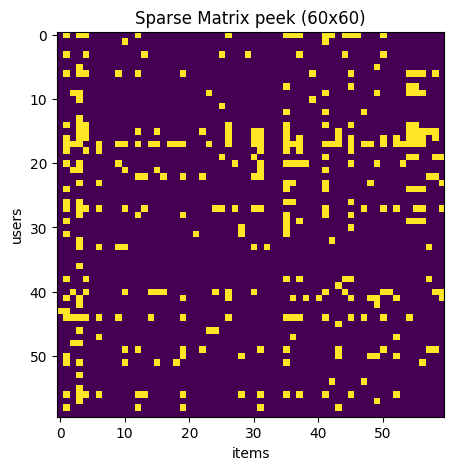


[Item-based CF] 데모 사용자 추천:
- The Sixth Sense (score=20.6954)
- The Godfather (score=19.6563)
- Pulp Fiction (score=19.1125)
- The Truman Show (score=17.9336)
- The Fifth Element (score=17.0362)
- Terminator 2: Judgment Day (score=16.3750)
- Aliens (score=16.1913)
- Die Hard (score=15.6441)
- Shrek (score=14.2318)
- Memento (score=13.2673)

[SVD(잠재요인) 기반] 데모 사용자 추천:
- The Fifth Element (score=25.7712)
- The Sixth Sense (score=24.7237)
- The Truman Show (score=24.4195)
- Die Hard (score=21.6206)
- Jaws (score=21.5524)
- Aliens (score=19.3011)
- Men in Black (score=16.9558)
- Terminator 2: Judgment Day (score=16.6697)
- Airplane! (score=16.2030)
- The Godfather (score=16.1930)

[제목 유사 입력 → 비슷한 영화 추천] 예시:
- Terminator 2: Judgment Day (sim=0.4673)
- Indiana Jones and the Last Crusade (sim=0.4490)
- The Terminator (sim=0.4311)
- The Empire Strikes Back (sim=0.4091)
- Indiana Jones and the Temple of Doom (sim=0.4056)
- Jurassic Park (sim=0.3980)
- Die Hard (sim=0.3926)
- The Crow (sim=0.3896

In [62]:
# =========================
# [CF 기본 실습: TMDB + (선택적) MovieLens]
# - Route A: 실제 평점 (ratings.csv, links.csv) 있으면 이를 사용
# - Route B: 없으면 TMDB 장르 기반으로 "교육용" 간이 상호작용 합성
# - Item-based CF(코사인) + 간단 잠재요인(SVD) 추천까지
# =========================

# [1] 라이브러리
import os, re, json, math, textwrap, random
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from difflib import get_close_matches
import matplotlib.pyplot as plt

# [2] 경로 설정 (사용자 환경에 맞게 ratings.csv/links.csv 경로가 있다면 입력)
TMDB_PATH = "/home/bmw/.cache/kagglehub/datasets/tmdb/tmdb-movie-metadata/versions/2/tmdb_5000_movies.csv"
# MovieLens 예: ml-latest-small 또는 25M 등. 아래는 예시 경로 리스트 (있으면 자동 선택)
CANDIDATE_RATINGS = [
    "./ratings.csv",
    "./ml-latest-small/ratings.csv",
    "./ml-25m/ratings.csv"
]
CANDIDATE_LINKS = [
    "./links.csv",
    "./ml-latest-small/links.csv",
    "./ml-25m/links.csv"
]

# [3] 데이터 로드: TMDB
movies = pd.read_csv(TMDB_PATH)
# 기본 전처리: id(int), title(str), genres(JSON str), popularity(float)
movies["id"] = movies["id"].astype(int)
movies["title"] = movies["title"].fillna("")

# TMDB 장르 텍스트화 (Route B에서 사용)
def parse_genres(x):
    try:
        arr = json.loads(x.replace("'", '"'))
        return " ".join(sorted([g["name"].replace(" ", "_") for g in arr if "name" in g]))
    except Exception:
        return ""
movies["genres_text"] = movies["genres"].apply(parse_genres)

# [4] MovieLens 존재 여부 탐색 (Route A 판단)
def first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            return p
    return None

ratings_path = first_existing(CANDIDATE_RATINGS)
links_path   = first_existing(CANDIDATE_LINKS)

route = "A" if (ratings_path and links_path) else "B"
print(f"학습 경로 선택: Route {route} "
      f"({'실제 평점 기반' if route=='A' else '교육용 합성 상호작용'})")

# [5] 사용자-아이템 상호작용 구성
# 공통 목표: user_id ↔ item_id(TMDB id)에 대한 행렬 R (sparse CSR)
if route == "A":
    # ---- Route A: 실제 평점 기반 ----
    ratings = pd.read_csv(ratings_path)
    links = pd.read_csv(links_path)
    # links는 MovieLens movieId ↔ 외부 id(TMDB/IMDB) 매핑 포함
    # TMDB id는 'tmdbId' 컬럼(없으면 -1). 일부는 NaN 일 수 있음
    if "tmdbId" not in links.columns:
        # 일부 배포본은 'tmdbId'가 없을 수 있음. 그 경우 IMDB로 조인 등 별도 처리 필요
        # 여기서는 간단히 사용 가능한 tmdbId가 있을 때만 진행
        raise ValueError("links.csv에 tmdbId가 없습니다. tmdbId 포함 버전을 사용하세요.")
    links = links.dropna(subset=["tmdbId"]).copy()
    links["tmdbId"] = links["tmdbId"].astype(int)

    # ratings(movieId) ↔ links(movieId) ↔ TMDB(id) 조인
    df = ratings.merge(links[["movieId","tmdbId"]], on="movieId", how="inner")
    df = df.rename(columns={"userId":"user", "tmdbId":"item", "rating":"rating"})
    # 범위 축소: TMDB_5000에 있는 영화만 남기기
    df = df[df["item"].isin(set(movies["id"]))].copy()

    # implicit/explicit 선택: 여기선 간단히 "평점 >= 3.5"를 1, 나머지 0으로 이진화(암묵적 피드백처럼)
    df["interact"] = (df["rating"] >= 3.5).astype(int)

    # 사용자/아이템 인덱싱
    user_index = {u:i for i,u in enumerate(df["user"].unique())}
    item_index = {it:i for i,it in enumerate(sorted(df["item"].unique()))}

    ui = df[["user","item","interact"]].copy()
    ui["u_idx"] = ui["user"].map(user_index)
    ui["i_idx"] = ui["item"].map(item_index)

    R = csr_matrix((ui["interact"].astype(float),
                    (ui["u_idx"], ui["i_idx"])),
                   shape=(len(user_index), len(item_index)))

    # 인덱스↔ID 매핑 보관
    idx2user = {i:u for u,i in user_index.items()}
    idx2item = {i:it for it,i in item_index.items()}

else:
    # ---- Route B: 교육용 합성 ----
    # 아이디어: 임의의 사용자들이 장르 선호 분포를 갖고, 해당 장르의 영화를 일부 시청(=1)했다고 가정
    rng = np.random.default_rng(42)
    n_users = 1200  # 교육용 규모
    # 장르 토큰 사전
    all_genres = sorted(set(" ".join(movies["genres_text"]).split()))
    if "" in all_genres:
        all_genres.remove("")

    # 각 사용자별로 1~3개 선호 장르를 랜덤 가중치로 선택
    user_pref = []
    for _ in range(n_users):
        k = rng.integers(1, 4)
        favs = rng.choice(all_genres, size=k, replace=False)
        user_pref.append(set(favs))

    # 장르→영화 역색인
    genre_to_items = {g: set(movies.loc[movies["genres_text"].str.contains(g), "id"].tolist())
                      for g in all_genres}

    # 사용자별 상호작용 샘플링(간단): 선호 장르 합집합에서 10~40편 시청했다고 가정
    rows, cols, data = [], [], []
    chosen_items = set()
    for u, favs in enumerate(user_pref):
        candidate = set()
        for g in favs:
            candidate |= genre_to_items.get(g, set())
        candidate = list(candidate)
        if len(candidate) == 0:
            continue
        m = rng.integers(10, min(40, len(candidate))+1)
        items = rng.choice(candidate, size=m, replace=False)
        for it in items:
            rows.append(u)
            cols.append(it)  # TMDB id 그대로 쓰지 말고, 인덱스로 바꿔야 함
            data.append(1.0)
            chosen_items.add(it)

    # item 인덱싱 (선택된 아이템만)
    chosen_items = sorted(list(chosen_items))
    item_index = {it:i for i,it in enumerate(chosen_items)}
    idx2item = {i:it for it,i in item_index.items()}

    # 행렬 구성
    rows_idx = np.array(rows, dtype=int)
    cols_idx = np.array([item_index[it] for it in cols], dtype=int)
    data_arr = np.array(data, dtype=float)
    R = csr_matrix((data_arr, (rows_idx, cols_idx)),
                   shape=(n_users, len(item_index)))

    # idx2user (교육용: 0..n_users-1)
    idx2user = {i:i for i in range(R.shape[0])}

# [6] 스파스 행렬 상태 확인(모양, 밀도 등)
print(f"R shape = {R.shape}  # (num_users, num_items)")
density = R.nnz / (R.shape[0]*R.shape[1])
print(f"sparsity(희소율) ≈ {1 - density:.4f} (밀도={density:.6f})")

# 작은 부분 행렬 시각화(상위 60x60만)
def peek_sparse(R, nu=60, ni=60):
    U = min(nu, R.shape[0])
    I = min(ni, R.shape[1])
    sub = R[:U, :I].toarray()
    plt.figure(figsize=(5,5))
    plt.imshow(sub, aspect='auto')
    plt.title(f"Sparse Matrix peek ({U}x{I})")
    plt.xlabel("items")
    plt.ylabel("users")
    plt.show()

peek_sparse(R)

# [7] 보조 매핑: item_idx -> title
# Route A: idx2item(TMDb id) -> title
# Route B: 동일
tmdb_id_to_title = dict(zip(movies["id"], movies["title"]))
def title_of_item_idx(i_idx):
    tmdb_id = idx2item.get(i_idx, None)
    return tmdb_id_to_title.get(tmdb_id, f"tmdb:{tmdb_id}")

# [8] Item-based CF: 아이템-아이템 코사인 유사도
# R: (U x I) -> 열 정규화 후 I x I 유사도 계산(메모리 절약 위해 top-K만 구하는 게 실전적이지만, 여기선 기본형)
# 실무: 매우 큰 카탈로그면 FAISS/Annoy/ScaNN 등 근사최근접 탐색이 필요
# 여기선 교육용으로 전체 코사인 유사도(메모리 주의) 대신, 질의 아이템 주변만 동적으로 계산하는 함수로 구현
from numpy.linalg import norm

# 아이템 벡터 접근(열) 함수
def item_vector(i_idx):
    # csr의 특정 열은 느릴 수 있어 T 전치 활용
    return R[:, i_idx].toarray().ravel()

def cosine(a, b):
    na, nb = norm(a), norm(b)
    if na==0 or nb==0: return 0.0
    return float(np.dot(a, b) / (na*nb))

def top_similar_items(i_idx, topn=20):
    v = item_vector(i_idx)
    sims = []
    for j in range(R.shape[1]):
        if j == i_idx: 
            continue
        s = cosine(v, item_vector(j))
        if s > 0:
            sims.append((j, s))
    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topn]

# [9] 사용자 히스토리 기반 추천 (Item-based CF)
# 간단 룰: 사용자가 상호작용한 아이템들의 유사 아이템을 모아 점수화(합산) 후 추천
def recommend_item_based_for_user(u_idx, topn=10, exclude_consumed=True):
    user_row = R[u_idx, :].toarray().ravel()
    consumed = np.where(user_row > 0)[0]
    scores = {}
    for i_idx in consumed:
        for j_idx, s in top_similar_items(i_idx, topn=50):
            if exclude_consumed and j_idx in consumed:
                continue
            scores[j_idx] = scores.get(j_idx, 0.0) + s
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]
    return [(title_of_item_idx(j), score) for j, score in ranked]

# 데모: 임의 사용자 하나 추천
print("\n[Item-based CF] 데모 사용자 추천:")
demo_user = 0
rec = recommend_item_based_for_user(demo_user, topn=10)
for t, s in rec:
    print(f"- {t} (score={s:.4f})")

# [10] 모델 기반 CF(간단): TruncatedSVD로 잠재요인 추출 후, 잠재공간 코사인 유사도
# R ~ U S V^T 에서 V_k (아이템 잠재벡터)만 뽑아 아이템-아이템 유사도/추천에 사용
# (실무의 MF/ALS와 수학적 목적은 다르지만 "잠재공간에서 비슷한 아이템" 직관을 훈련하기 좋음)
svd = TruncatedSVD(n_components=64, random_state=42)
# 사용자-아이템 행렬에서 아이템 잠재벡터 = R^T * W 꼴로 생각하면, fit_transform(R.T)로 곧장 아이템 임베딩 생성
item_latent = svd.fit_transform(R.T)  # shape: (I, k)

def top_sim_items_in_latent(i_idx, topn=20):
    v = item_latent[i_idx].reshape(1, -1)
    sims = cosine_similarity(v, item_latent)[0]   # 전체 대비 코사인 (교육용)
    order = np.argsort(-sims)
    res = []
    for j in order:
        if j == i_idx: 
            continue
        res.append((j, float(sims[j])))
        if len(res) >= topn:
            break
    return res

def recommend_svd_item_based_for_user(u_idx, topn=10, exclude_consumed=True):
    user_row = R[u_idx, :].toarray().ravel()
    consumed = np.where(user_row > 0)[0]
    scores = {}
    for i_idx in consumed:
        for j_idx, s in top_sim_items_in_latent(i_idx, topn=50):
            if exclude_consumed and j_idx in consumed:
                continue
            scores[j_idx] = scores.get(j_idx, 0.0) + s
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topn]
    return [(title_of_item_idx(j), score) for j, score in ranked]

print("\n[SVD(잠재요인) 기반] 데모 사용자 추천:")
rec2 = recommend_svd_item_based_for_user(demo_user, topn=10)
for t, s in rec2:
    print(f"- {t} (score={s:.4f})")

# [11] 사용자 입력(대략적인 영화 제목)으로 "해당 영화를 본 사용자" 가정하고 비슷한 영화 추천
# - 실제론 "그 영화를 본 사용자들의 패턴"이 반영되어 근접 아이템이 나옴 (Item-based CF 직관 확인)
titles = movies[["id","title"]].copy()

def fuzzy_find_title(q, topn=5):
    # 간단 모호매칭
    pool = titles["title"].tolist()
    matches = get_close_matches(q, pool, n=topn, cutoff=0.5)
    return matches

def recommend_from_title_like(query_title, topn=10, use_svd=False):
    # 1) 입력 제목을 모호 매칭
    cand = fuzzy_find_title(query_title, topn=1)
    if not cand:
        print(f"'{query_title}' 와 유사한 제목을 찾지 못했어요.")
        return []
    base_title = cand[0]
    # 2) 해당 타이틀의 item_idx 찾기
    row = titles[titles["title"] == base_title]
    tmdb_id = int(row["id"].iloc[0])
    # item_idx 변환
    inv = {v:k for k,v in idx2item.items()}
    if tmdb_id not in inv:
        print(f"[경고] 선택한 영화가 상호작용 행렬에 없습니다. (Route B에서 합성에 안 들어갔을 수 있음)")
        return []
    i_idx = inv[tmdb_id]
    # 3) 비슷한 아이템 반환
    if use_svd:
        sims = top_sim_items_in_latent(i_idx, topn=topn)
    else:
        sims = top_similar_items(i_idx, topn=topn)
    return [(title_of_item_idx(j), s) for j,s in sims]

print("\n[제목 유사 입력 → 비슷한 영화 추천] 예시:")
for t, s in recommend_from_title_like("batman", topn=10, use_svd=False):
    print(f"- {t} (sim={s:.4f})")
